In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import random
import os

%matplotlib inline

Mounted at /content/drive


In [ ]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

is_use_gpu = True
if is_use_gpu:
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    os.environ['TF_USE_CUDNN'] = '1'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [ ]:
train_dir = '/content/drive/MyDrive/people-dataset/train'
test_dir = '/content/drive/MyDrive/people-dataset/test'

image_size = 224

vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in vgg_conv.layers[:]:
    layer.trainable = False

model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 100
test_batchsize = 10

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 40409924 (154.15 MB)
Trainable params: 25695236 (98.02 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=20,
      verbose=1)

Epoch 1/20
8/8 [==============================] - 146s 17s/step - loss: 2.3739 - acc: 0.4650
Epoch 2/20
8/8 [==============================] - 8s 958ms/step - loss: 0.3655 - acc: 0.8650
Epoch 3/20
8/8 [==============================] - 8s 938ms/step - loss: 0.2724 - acc: 0.8888
Epoch 4/20
8/8 [==============================] - 8s 942ms/step - loss: 0.2063 - acc: 0.9275
Epoch 5/20
8/8 [==============================] - 8s 946ms/step - loss: 0.1597 - acc: 0.9388
Epoch 6/20
8/8 [==============================] - 8s 931ms/step - loss: 0.2004 - acc: 0.9275
Epoch 7/20
8/8 [==============================] - 8s 938ms/step - loss: 0.0434 - acc: 0.9912
Epoch 8/20
8/8 [==============================] - 8s 951ms/step - loss: 0.0511 - acc: 0.9887
Epoch 9/20
8/8 [==============================] - 8s 982ms/step - loss: 0.3114 - acc: 0.8988
Epoch 10/20
8/8 [==============================] - 8s 964ms/step - loss: 0.0311 - acc: 0.9925
Epoch 11/20
8/8 [==============================] - 8s 986ms/step - lo

In [ ]:
model.save('model.h5')

In [ ]:
predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

20/20 [==============================] - 50s 3s/step


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

20/20 [==============================] - 2s 88ms/step - loss: 0.0562 - acc: 0.9850
Test Accuracy: 98.50%


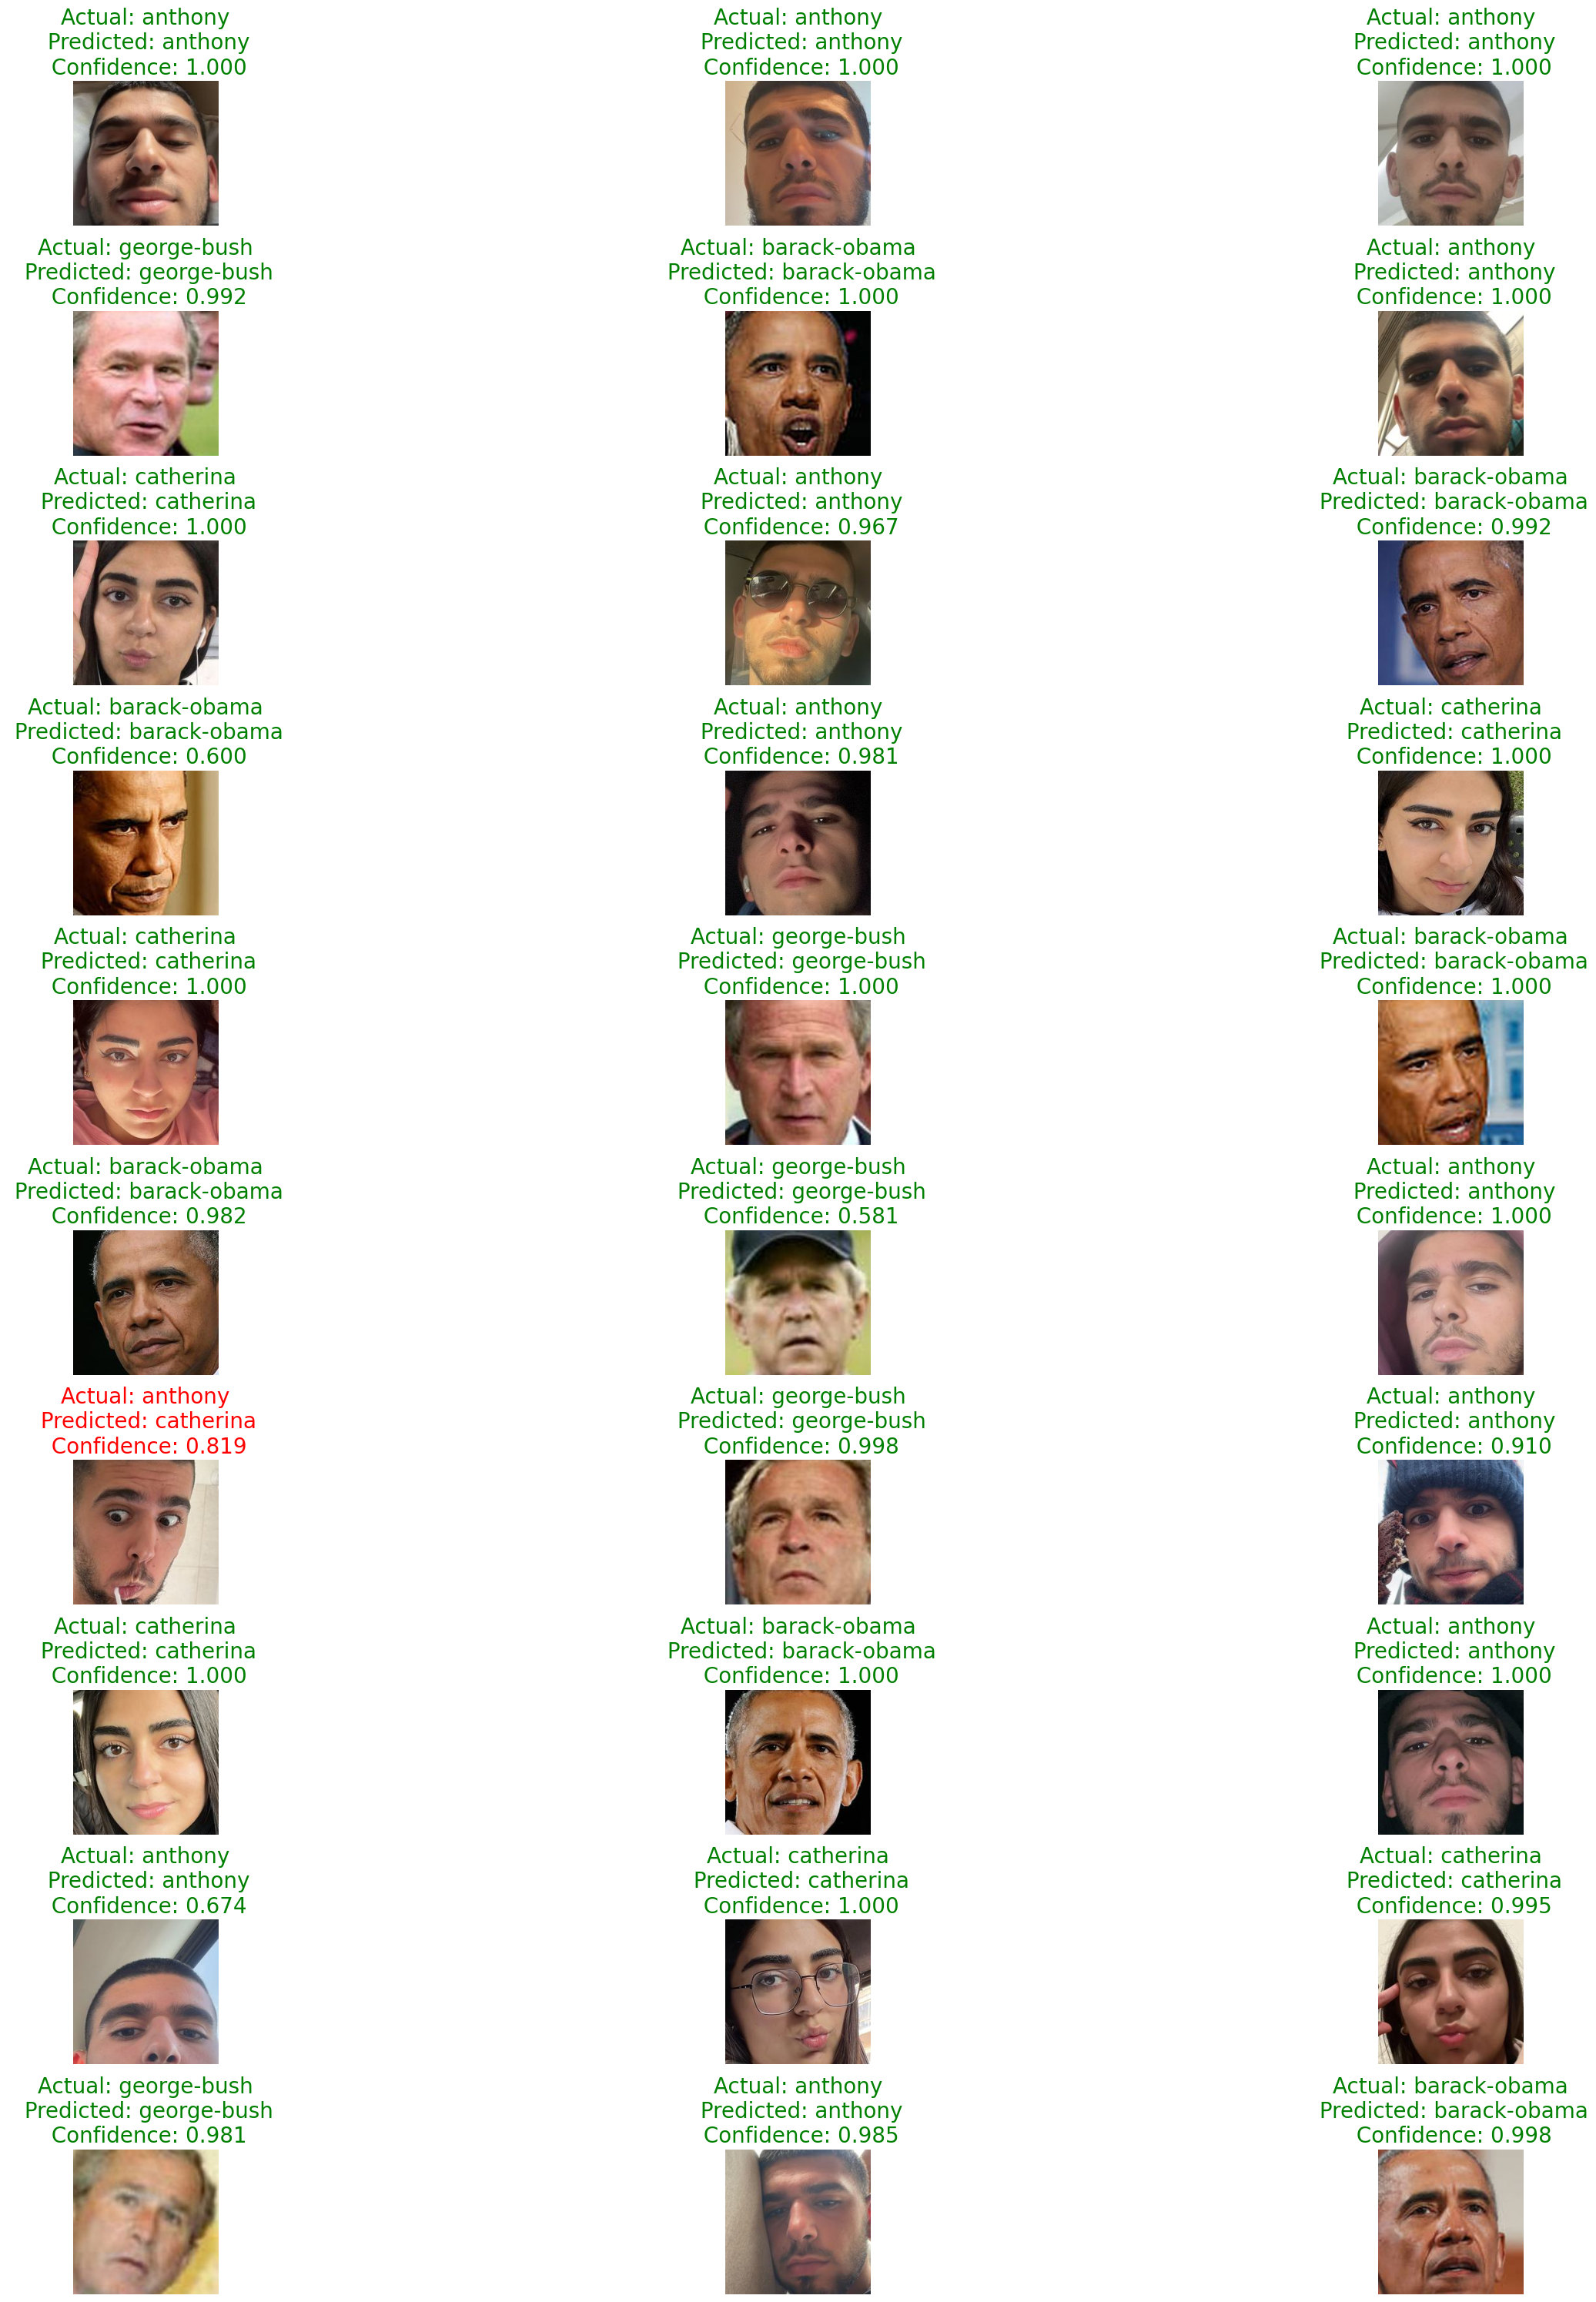

In [ ]:
def show_predictions(test_generator, predictions, num_samples=30):
    idx2label = list(test_generator.class_indices.keys())
    sample_indices = np.random.choice(len(predictions), min(num_samples, len(predictions)), replace=False)
    fnames = test_generator.filenames
    ground_truth = test_generator.classes

    plt.figure(figsize=(30, 30))
    for index, i in enumerate(sample_indices, 1):
        pred_class = np.argmax(predictions[i])
        actual_class = ground_truth[i]
        pred_label = idx2label[pred_class]
        actual_label = idx2label[actual_class]
        correct = pred_class == actual_class

        title = 'Actual: {}\n Predicted: {}\n Confidence: {:.3f}'.format(
            actual_label,
            pred_label,
            predictions[i][pred_class])
        title_color = 'green' if correct else 'red'

        img = load_img('{}/{}'.format(test_dir, fnames[i]))
        plt.subplot(10, 3, index)
        plt.imshow(img)
        plt.title(title, color=title_color, fontsize=20)
        plt.axis('off')

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.tight_layout()
    plt.show()


show_predictions(test_generator, predictions, 30)
